In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prophet

%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

Load Data

In [3]:
def load_data(path='C:\\Users\\Oluwajuwon\\Documents\\Smart Systems\\Projects\\Data Science Projects\\combined_data.csv'):
    return pd.read_csv(path)

In [4]:
meters = load_data()
meters.head()

,Unnamed: 0,meter_id,w_timestamp,current,voltage,frequency,power_factor,energy,real_power,reactive_power,apparent_power,tita,hour,time_diff
0,0,OND023,2022-07-12 13:57:30.449294+00:00,0.79,210.1,50.1,0.75,NaN,0.124484,0.109785,0.165979,41.409622,14,0.009675
1,1,OND023,2022-07-12 13:58:42.793010+00:00,0.80,210.6,50.0,0.75,0.002539,0.126360,0.111439,0.168480,41.409622,14,0.009675
2,2,OND023,2022-07-12 14:00:28.080361+00:00,0.85,208.3,50.0,0.74,0.003832,0.131021,0.119088,0.177055,42.268584,15,0.009675
3,3,OND023,2022-07-12 14:01:00.914557+00:00,0.74,208.5,50.0,0.76,0.001069,0.117260,0.100277,0.154290,40.535802,15,0.009675
4,4,OND023,2022-07-12 14:01:34.931821+00:00,0.74,208.1,49.9,0.76,0.001106,0.117035,0.100084,0.153994,40.535802,15,0.009675


In [5]:
meters.shape

(306708, 14)

In [6]:
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306708 entries, 0 to 306707
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      306708 non-null  int64  
 1   meter_id        306708 non-null  object 
 2   w_timestamp     306708 non-null  object 
 3   current         306708 non-null  float64
 4   voltage         306708 non-null  float64
 5   frequency       306708 non-null  float64
 6   power_factor    306708 non-null  float64
 7   energy          306705 non-null  float64
 8   real_power      306708 non-null  float64
 9   reactive_power  306708 non-null  float64
 10  apparent_power  306708 non-null  float64
 11  tita            306708 non-null  float64
 12  hour            306708 non-null  int64  
 13  time_diff       306708 non-null  float64
dtypes: float64(10), int64(2), object(2)
memory usage: 32.8+ MB


In [7]:
on23 = meters[meters['meter_id'] == "OND023"]
oy21 = meters[meters['meter_id'] == "OYO021"]
on21 = meters[meters['meter_id'] == "OND021"]
on24 = meters[meters['meter_id'] == "OND024"]

In [8]:
def clean(df):
    df = df.copy().dropna(axis='index')
    df = df.drop(columns=['Unnamed: 0','meter_id','tita','hour','time_diff'])
    df = df.rename(columns={'w_timestamp':'timestamp'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [9]:
df = clean(on23)

In [10]:
df_energy = df[['timestamp','energy']]
df_energy

,timestamp,energy
1,2022-07-12 13:58:42.793010+00:00,0.002539
2,2022-07-12 14:00:28.080361+00:00,0.003832
3,2022-07-12 14:01:00.914557+00:00,0.001069
4,2022-07-12 14:01:34.931821+00:00,0.001106
5,2022-07-12 14:02:10.738666+00:00,0.001164
...,...,...
161079,2022-10-22 21:35:34.272836+00:00,0.003651
161080,2022-10-22 21:36:08.484019+00:00,0.003300
161081,2022-10-22 21:36:43.545834+00:00,0.003368
161082,2022-10-22 21:38:28.735422+00:00,0.007590


In [11]:
data_len = len(df_energy)
test_size = int(0.2*data_len)
train = df_energy[:-test_size]
test = df_energy[-test_size:]

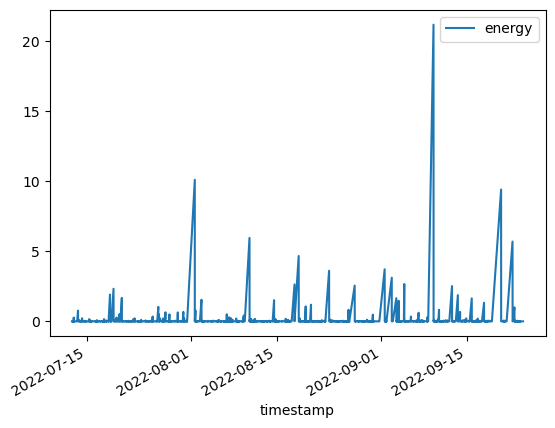

In [12]:
train.set_index('timestamp').plot();

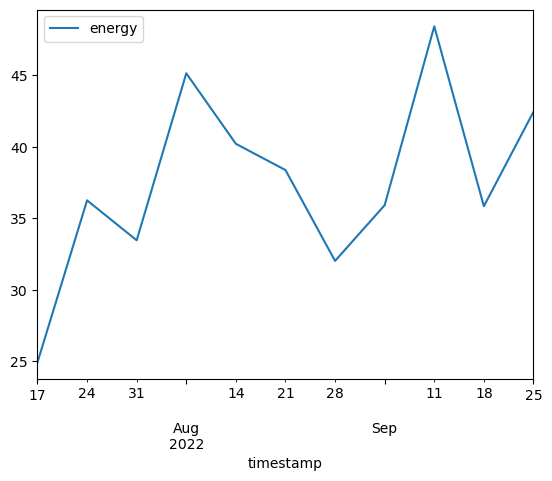

In [13]:
train.set_index('timestamp').resample('W').sum().plot();

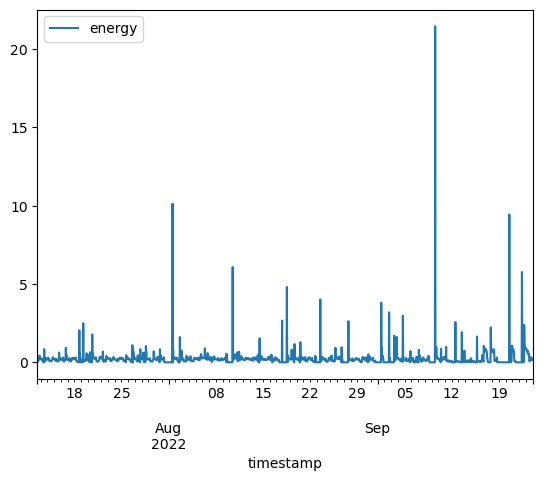

In [14]:
train.set_index('timestamp').resample('H').sum().plot(legend=True);

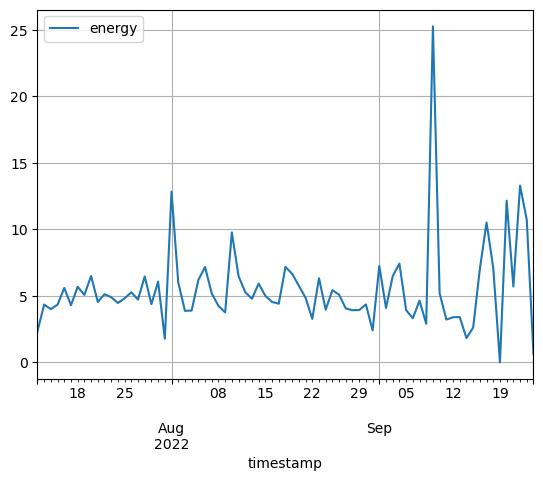

In [15]:
train.set_index('timestamp').resample('D').sum().plot(grid=True);

In [16]:
train,test = train.rename(columns={'timestamp':'ds','energy':'y'}),test.rename(columns={'timestamp':'ds','energy':'y'})
train['ds'] = train['ds'].dt.tz_localize(None)
test['ds'] = test['ds'].dt.tz_localize(None)

In [17]:
import prophet

In [18]:
model = prophet.Prophet()

In [21]:
%%time
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Wall time: 15.3 s


In [22]:
test_fct = model.predict(test)

C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [23]:
test_fct

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-09-24 03:46:10.399657,0.005680,-0.093062,0.112023,0.005680,0.005680,-0.000942,-0.000942,-0.000942,-0.001336,-0.001336,-0.001336,0.000394,0.000394,0.000394,0.0,0.0,0.0,0.004738
1,2022-09-24 03:46:45.184630,0.005680,-0.102518,0.109062,0.005680,0.005680,-0.000941,-0.000941,-0.000941,-0.001335,-0.001335,-0.001335,0.000394,0.000394,0.000394,0.0,0.0,0.0,0.004739
2,2022-09-24 03:47:20.273972,0.005680,-0.103149,0.104061,0.005680,0.005680,-0.000940,-0.000940,-0.000940,-0.001334,-0.001334,-0.001334,0.000394,0.000394,0.000394,0.0,0.0,0.0,0.004740
3,2022-09-24 03:47:55.547796,0.005680,-0.098857,0.094205,0.005680,0.005680,-0.000940,-0.000940,-0.000940,-0.001333,-0.001333,-0.001333,0.000394,0.000394,0.000394,0.0,0.0,0.0,0.004741
4,2022-09-24 03:48:31.562127,0.005680,-0.097197,0.112363,0.005680,0.005680,-0.000939,-0.000939,-0.000939,-0.001332,-0.001332,-0.001332,0.000393,0.000393,0.000393,0.0,0.0,0.0,0.004742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32211,2022-10-22 21:35:34.272836,0.008784,-0.095578,0.113482,0.007999,0.009495,-0.000130,-0.000130,-0.000130,0.000002,0.000002,0.000002,-0.000132,-0.000132,-0.000132,0.0,0.0,0.0,0.008654
32212,2022-10-22 21:36:08.484019,0.008784,-0.094354,0.112431,0.007999,0.009495,-0.000142,-0.000142,-0.000142,-0.000009,-0.000009,-0.000009,-0.000132,-0.000132,-0.000132,0.0,0.0,0.0,0.008642
32213,2022-10-22 21:36:43.545834,0.008784,-0.097547,0.116048,0.007999,0.009495,-0.000154,-0.000154,-0.000154,-0.000021,-0.000021,-0.000021,-0.000133,-0.000133,-0.000133,0.0,0.0,0.0,0.008630
32214,2022-10-22 21:38:28.735422,0.008784,-0.095467,0.115609,0.007999,0.009495,-0.000190,-0.000190,-0.000190,-0.000056,-0.000056,-0.000056,-0.000134,-0.000134,-0.000134,0.0,0.0,0.0,0.008594


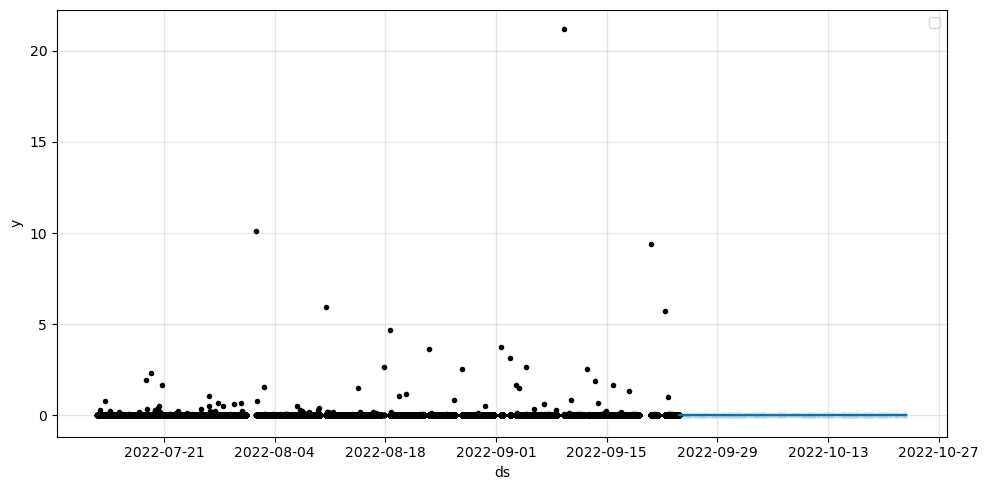

In [29]:
# plot predictions
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_fct, ax=ax)
plt.legend();

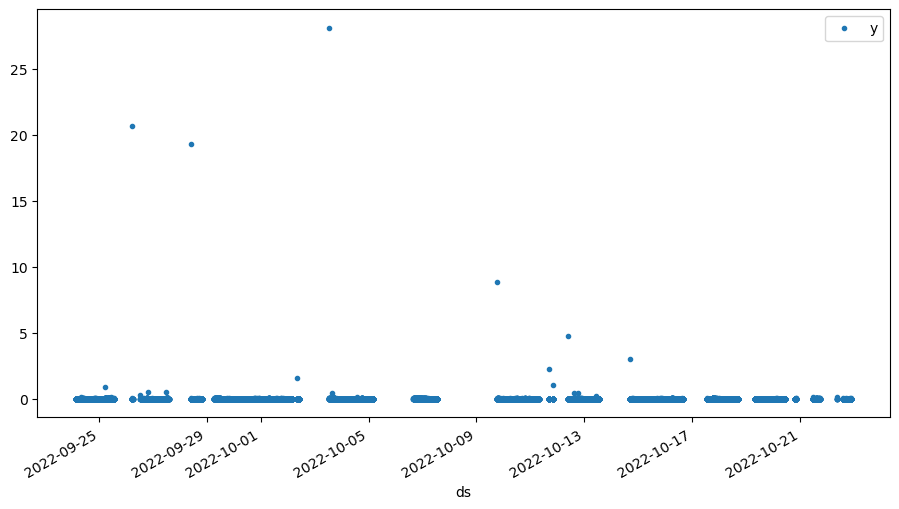

In [32]:
test.set_index('ds').plot(style='.', figsize=(11,6));

C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Oluwajuwon\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


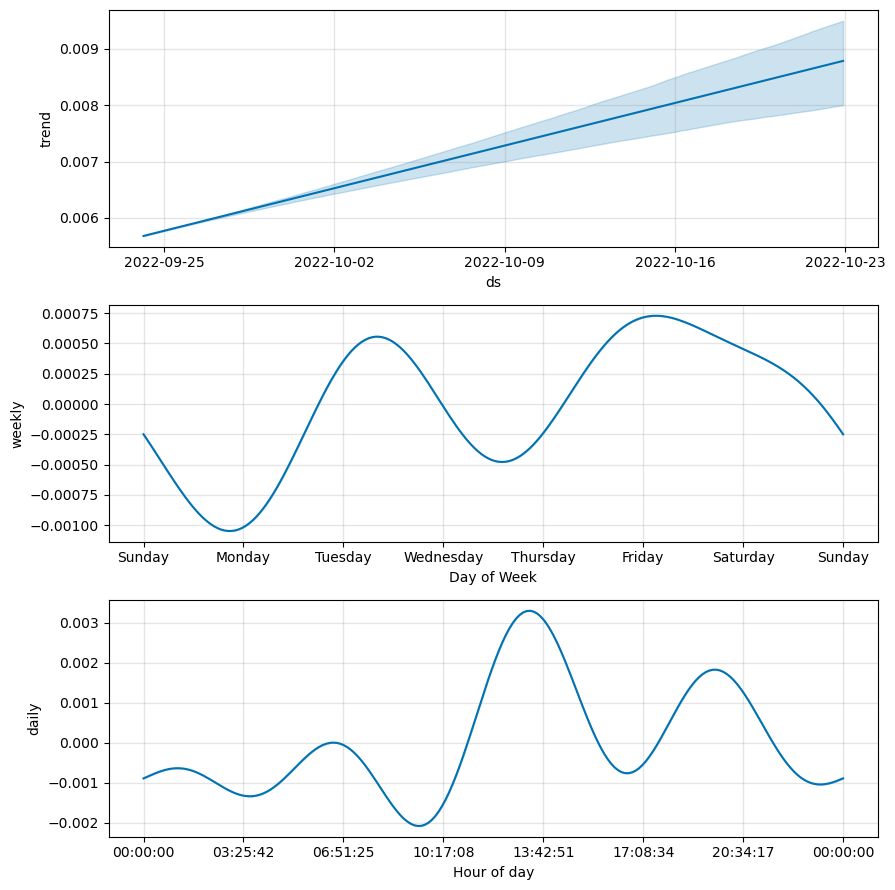

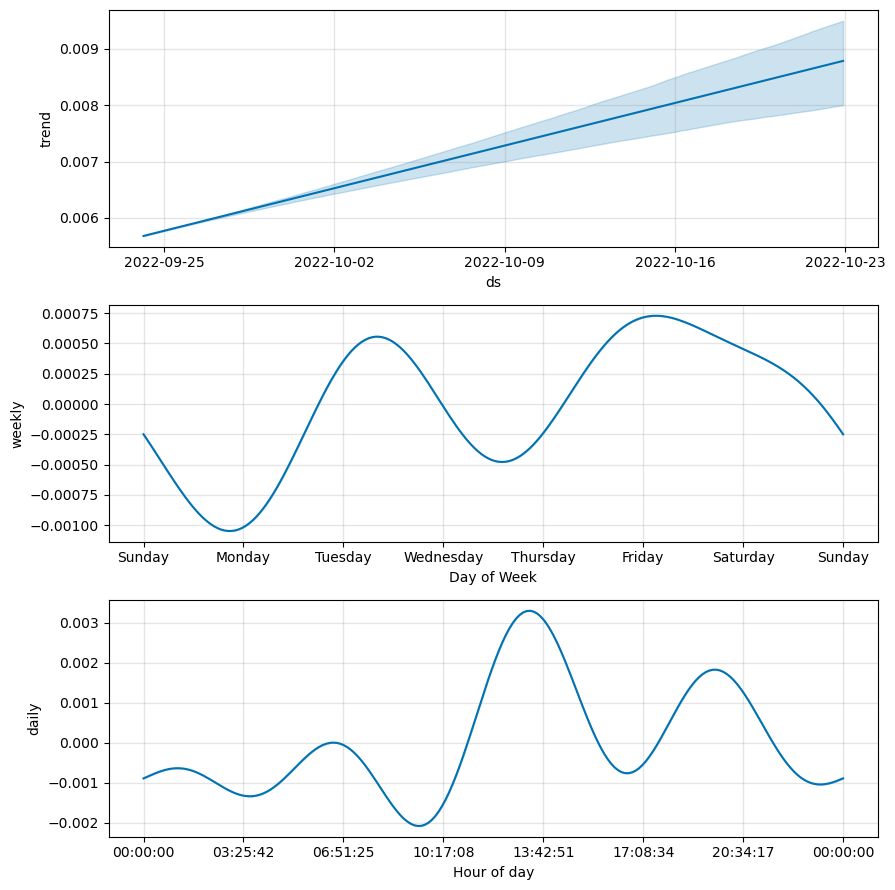

In [33]:
model.plot_components(test_fct)

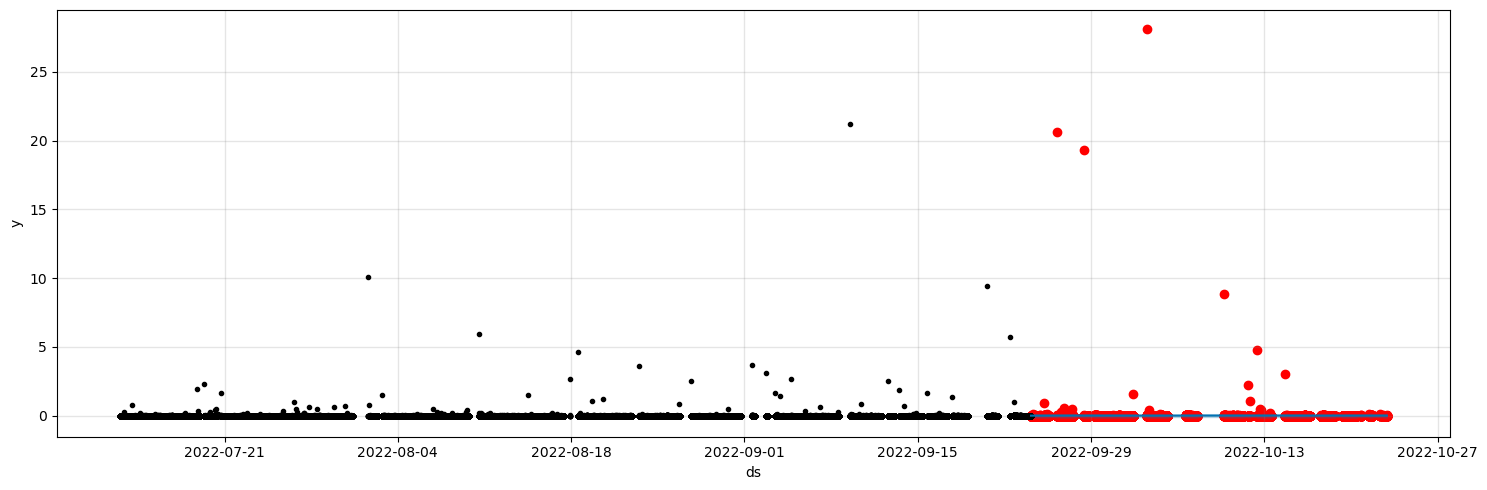

In [36]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test['ds'],test['y'],color='r')
fig = model.plot(test_fct,ax=ax,)

plt.title('Test vs Forcast')

In [39]:
from datetime import datetime

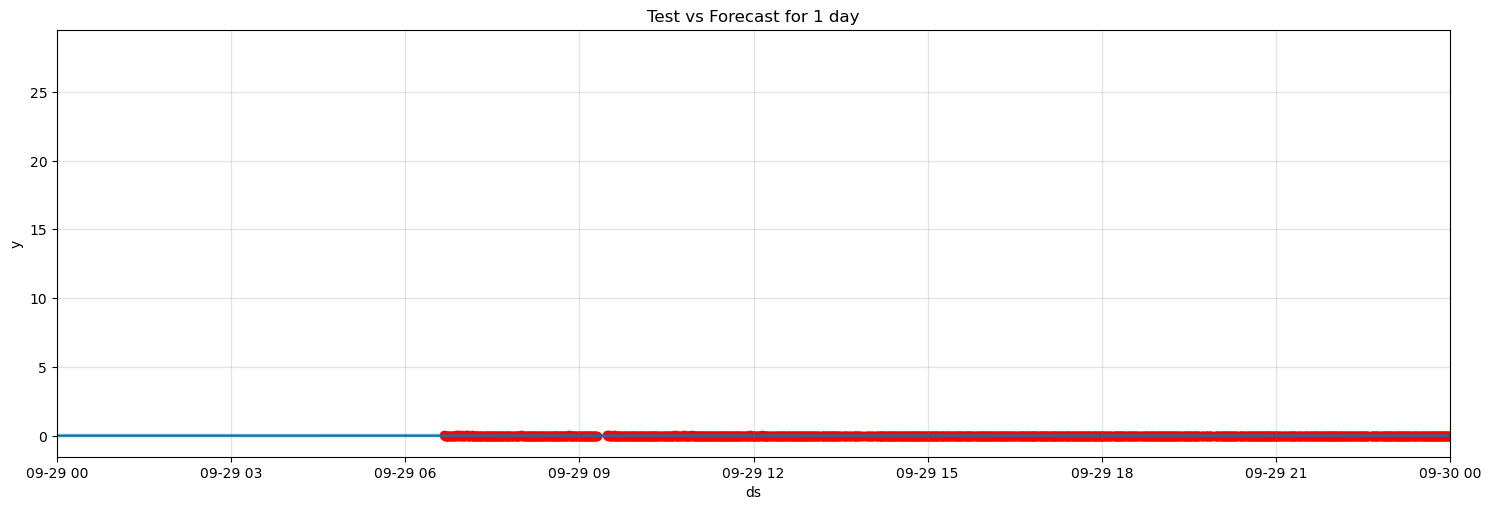

In [43]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test['ds'],test['y'],color='r')
fig = model.plot(test_fct,ax=ax,)
ax.set_xbound(datetime(2022,9,29),upper=datetime(2022,9,30))

plt.title('Test vs Forecast for 1 day');

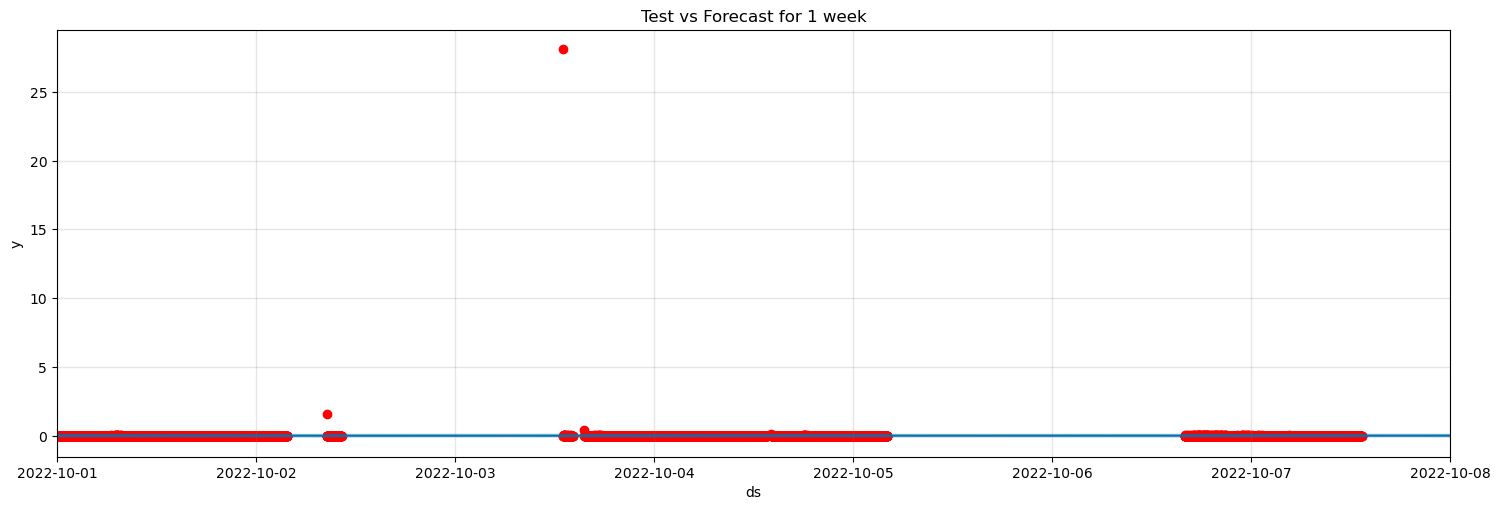

In [44]:
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(test['ds'],test['y'],color='r')
fig = model.plot(test_fct,ax=ax,)
ax.set_xbound(datetime(2022,10,1),upper=datetime(2022,10,8))

plt.title('Test vs Forecast for 1 week');

In [49]:
np.sqrt(mean_squared_error(test['y'],test_fct['yhat']))

0.23038646698247958

In [50]:
mean_absolute_error(test['y'], test_fct['yhat'])

0.007978604777076877

In [51]:
mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fct['yhat'])

4524.816013184992